# Part A

In [1]:
from pandas import Series, DataFrame
import pandas as pd
import nltk
import operator
import re,string
from patsy import dmatrices
%pylab inline

/Users/pranjor/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


## A1. What are the top 5 parts of speech in this corpus of job descriptions? How frequently do they appear?

### (1) import file

In [2]:
train = pd.read_csv('/Users/pranjor/Documents/UT/MSBA/Text Analytics/project 1/Train_rev1.csv')

train[:3]

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk


### (2) tokenize the corpus

In [3]:
description  = train['FullDescription'][:1000]

corpus = description.str.cat(sep=' ')

corpus = corpus.replace('****','')

corpus = corpus.decode('utf-8')

corpus_words = nltk.word_tokenize(corpus.lower())

### (3) Calculate the frequencies of PoS

In [6]:
pos = nltk.pos_tag(corpus_words)

pos[:10]

[(u'engineering', 'NN'),
 (u'systems', 'NNS'),
 (u'analyst', 'NN'),
 (u'dorking', 'VBG'),
 (u'surrey', 'JJ'),
 (u'salary', 'JJ'),
 (u'k', 'VB'),
 (u'our', 'PRP$'),
 (u'client', 'NN'),
 (u'is', 'VBZ')]

In [7]:
pos_freq = sorted(pos, key=lambda x: x[1],reverse=True)

df_pos = pd.DataFrame(pos_freq)


df_pos.columns = ['word','pos']

df_pos.groupby('pos').count().sort('word',ascending=False)[:5]

/Users/pranjor/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,word
pos,
NN,54170
JJ,23215
IN,22997
DT,17179
NNS,15575


## A2. Does this corpus support Zipf’s law? Plot the most common 100 words in the corpus against the theoretical prediction of the law.

### (1) Calculate the frequencies of words

In [8]:
fdist = nltk.FreqDist(corpus_words)

In [9]:
c_sorted = sorted(fdist.items(), key=operator.itemgetter(1),reverse=True)

df = pd.DataFrame.from_records(c_sorted)
df.columns = ['word','freq']
df[:10]

,word,freq
0,and,8436
1,.,8005
2,the,7121
3,",",6932
4,to,6677
5,a,5813
6,of,4547
7,in,4229
8,for,3450
9,care,3033


### (2) Get rid of the punctuation marks and then rank 

In [10]:
mask = ~df['word'].isin(set(string.punctuation)) 

df = df[mask]

df['rank'] = df['freq'].rank(method='min',ascending=False)

In [11]:
df[:5][['word','freq','rank']]

,word,freq,rank
0,and,8436,1.0
2,the,7121,2.0
4,to,6677,3.0
5,a,5813,4.0
6,of,4547,5.0


### (3) Plot the most common 100 words in the corpus against the theoretical prediction of the law

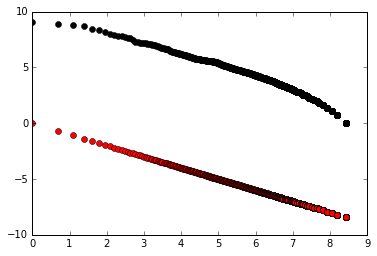

In [12]:
df['x^-1']= [c**-1 for c in df['rank']]

import matplotlib.pyplot as plt

fig = plt.figure()

ax = plt.plot([math.log(c) for c in df['rank'].values], [math.log(c) for c in df['freq']], 'ro',color='black')

ax2 = plt.plot([math.log(c) for c in df['rank'].values], [math.log(c) for c in df['x^-1']], 'ro')

## A3. If we remove stopwords and lemmatize the corpus, what are the 10 most common words? What is their frequency?

In [13]:
from nltk.corpus import stopwords

from nltk.stem import PorterStemmer, WordNetLemmatizer

corpus_words= [word for word in corpus_words if word not in set(string.punctuation)]

filtered_words_sw = [word for word in corpus_words if word not in stopwords.words('english')]

wnl = WordNetLemmatizer()
words_lem = [wnl.lemmatize(word) for word in filtered_words_sw]

fdist_2 = nltk.FreqDist(words_lem)
fdist_2.most_common(10)

[(u'care', 3060),
 (u'home', 2117),
 (u'experience', 1366),
 (u'manager', 1276),
 (u'nurse', 1266),
 (u'work', 1201),
 (u'nursing', 1180),
 (u'support', 1093),
 (u'within', 1040),
 (u'working', 965)]

  ## B1 Create a classification model with all words and the bag-of-words approach. How accurate is the model (show the confusion matrix)? 

In [65]:
#create a function that counts the frequency of each token in a document
def document_features(document):
    document_words = set(document)
    features = {}
    for word in corpus_words:
        features['contains({})'.format(word)] = (word in document_words)
    return features

In [66]:
#find the cutoff salary
cutoff = np.percentile(train[['SalaryNormalized']], 75)
train['category'] = 'high'
train.ix[train.SalaryNormalized < cutoff, 'category'] = 'low'

train['token'] = ""
fullset = train[['FullDescription','token','category']][:1000]

#calculate the document_features in each document
from __future__ import unicode_literals
for i in range(len(fullset)):
    words = re.sub(r'[^\w\s]','',fullset.FullDescription[i])
    token = nltk.word_tokenize(words.lower().decode('utf-8'))
    feature = document_features(token)
    fullset.token[i] = feature

In [67]:
fullset['feature_sets'] = zip(fullset.token, fullset.category)
featuresets = fullset.feature_sets.tolist()
train_set, test_set = featuresets[:500], featuresets[500:]
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [68]:
print 'the accuracy is ', nltk.classify.accuracy(classifier, test_set)

the accuracy is  0.814


## B2 . Speculate before running the following analysis whether lemmatization would help improve the accuracy of classification. Now create a classification model after lemmatization. Did the classification accuracy increase relative to B1? Comment on your speculation versus the actual results you obtained. 

The lemmtization should improve the accuracy since there will be fewer tokens. With each token appearing in a document, the likelihood of the document being positive or negative will increase.

In [58]:
for i in range(len(fullset)):
    words = re.sub(r'[^\w\s]','',fullset.FullDescription[i])
    token = nltk.word_tokenize(words.lower().decode('utf-8'))
    lemma = [wnl.lemmatize(word) for word in token]
    feature = document_features(lemma)
    fullset.token[i] = feature

In [60]:
fullset['feature_sets'] = zip(fullset.token, fullset.category)
featuresets = fullset.feature_sets.tolist()
train_set, test_set = featuresets[:500], featuresets[500:]
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [63]:
print 'the accuracy is ', nltk.classify.accuracy(classifier, test_set)

the accuracy is  0.812


After lemmatization, the accuracy actually went down from 0.814 to 0.812. Perhaps it's because the lemmatized words have more similar likelihood in both high and low salary categories than the pre-lemmatized words.